In [1]:
%reload_ext autoreload
%autoreload 2

In [2]:
from src.load_data import load_data, get_position_info
import xarray as xr
from src.parameters import ANIMALS
from replay_trajectory_classification import ClusterlessClassifier
from scipy.io import loadmat
import numpy as np

epoch_key = 'Jaq', 3, 16
animal, day, epoch = epoch_key
data = load_data(epoch_key)

cm_to_pixels = np.asarray([0.1602, 0.1712])

results = xr.open_dataset(
    f'{ANIMALS["Jaq"].directory}/decoding_clusterless/'
    f'{animal}_{day}_{epoch}_cv_classifier_clusterless_vel_0_nose_alltime5x_results.nc')

classifier = ClusterlessClassifier.load_model(
    f'{ANIMALS["Jaq"].directory}/decoding_clusterless/'
    f'{animal}_{day}_{epoch}_cv_classifier_clusterless_nose.pkl')

uninterpolated_position_info = get_position_info(
    epoch_key, skip_linearization=True)
video_time = np.asarray(uninterpolated_position_info.index / np.timedelta64(1, 's'))

forvideo_data = loadmat('Jaq_d3_ep16_forvideo.mat')
forelimbL_plant_times = forvideo_data['forelimbL_plants']
forelimbR_plant_times = forvideo_data['forelimbR_plants']

video_filename = '20190829_Jaq_16_wtrack_increasedbrightness_hflp.mp4'

In [3]:
from tqdm.auto import tqdm
import numpy as np
import seaborn as sns
import cv2
import matplotlib.animation as animation
import matplotlib.pyplot as plt

plt.style.use('dark_background')


def get_2D_map_estimate(posterior, decoder):
    map_position_ind = (
        posterior.where(decoder.is_track_interior_).argmax(
            "position", skipna=True).values
    )
    try:
        bin_center_2D_position = decoder.place_bin_center_2D_position_
    except AttributeError:
        bin_center_2D_position = np.asarray(
            decoder
            .place_bin_centers_nodes_df_
            .loc[:, ["x_position", "y_position"]])

        
    return bin_center_2D_position[map_position_ind]


def get_plant_time_ind(forelimb_plant_times, time_slice, decoder_time):
    forelimb_plant_times = forelimb_plant_times.squeeze()
    forelimb_plant_times = forelimb_plant_times[
        (forelimb_plant_times >= time_slice.start) & 
        (forelimb_plant_times <= time_slice.stop)]

    return np.digitize(forelimb_plant_times, np.asarray(decoder_time)[1:-1])

## Video 1

Animal running 8x slowed down speed with all limbs tracked [nose-tail-forelimbs-hindlimbs] - no decode

In [4]:
def make_movie_with_video1(time_slice, data, video_time,
                          cm_to_pixels, video_filename, video_slowdown=8,
                           movie_name='video_name.mp4', sampling_frequency=500):
    
    video_mp4 = cv2.VideoCapture(video_filename)
    
    position_info = (data['position_info']
                 .set_index(data['position_info'].index / np.timedelta64(1, 's'))
                 .loc[time_slice])
    
    video_time_ind = np.digitize(position_info.index, video_time[1:-1])
    
    bodyparts_to_rgb = {
        'nose': (46, 49, 146),
        'forepawL': (247, 149, 32),
        'forepawR': (134, 76, 158),
    }
    
    # Set up formatting for the movie files
    Writer = animation.writers['ffmpeg']
    fps = sampling_frequency // video_slowdown
    writer = Writer(fps=fps, bitrate=-1)

    fig, ax = plt.subplots(1, 1, figsize=(6.4, 6.4))
    fig.patch.set_facecolor('black')
    plt.subplots_adjust(top=1, bottom=0, right=1, left=0, 
            hspace=0, wspace=0)
    
    is_grabbed, frame = video_mp4.read()
    if is_grabbed:
        frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
        im = ax.imshow(frame, animated=True, zorder=-1)
    ax.axis('off')
    
    bodyparts_dot = {}
    for bodypart, color in bodyparts_to_rgb.items():
        bodyparts_dot[bodypart] = ax.scatter(
            [], [], s=100, zorder=100, color=np.asarray(color)/255,
            label=bodypart, alpha=0.7)

    n_frames = position_info.shape[0]
    progress_bar = tqdm()
    progress_bar.reset(total=n_frames)

    def _update_plot(time_ind):
        progress_bar.update()
        
        # Video
        video_mp4.set(1, video_time_ind[time_ind])
        is_grabbed, frame = video_mp4.read()
        if is_grabbed:
            frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
            im.set_array(frame)

        for bodypart_name, bodypart_dot in bodyparts_dot.items():
            try:
                bodypart_position = np.asarray(
                    position_info[[f'{bodypart_name}_x', f'{bodypart_name}_y']]
                    .iloc[time_ind])
                bodypart_position /= cm_to_pixels
                bodypart_position[0] = frame.shape[1] - bodypart_position[0]
                bodypart_dot.set_offsets(bodypart_position)
            except KeyError:
                pass

        return (im, *tuple(bodyparts_dot.values()))
    
    movie = animation.FuncAnimation(fig, _update_plot, frames=n_frames,
                                    interval=1000/fps, blit=True)
    if movie_name is not None:
        movie.save(movie_name, writer=writer, dpi=200)

    return fig, movie

0it [00:00, ?it/s]

(<Figure size 460.8x460.8 with 1 Axes>,
 <matplotlib.animation.FuncAnimation at 0x7f1ed8296668>)

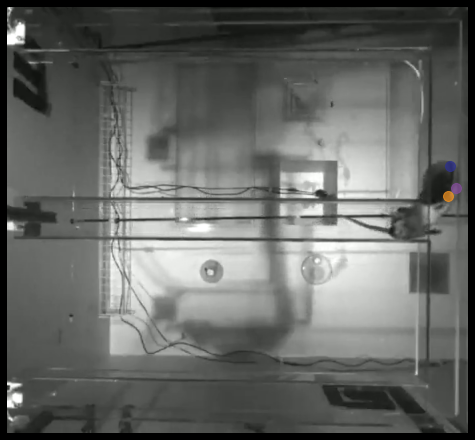

In [282]:
time_slice = slice(22559.4, 22560.4)
movie_name = 'video1.mp4'

make_movie_with_video1(time_slice, data, video_time, cm_to_pixels, video_filename,
                       movie_name=movie_name, video_slowdown=16)

In [283]:
from ipywidgets import Video

Video.from_file(movie_name)

Video(value=b'\x00\x00\x00 ftypisom\x00\x00\x02\x00isomiso2avc1mp41\x00\x00\x00\x08free\x00\x0c\x84\x0fmdat\x0…

## Video 2

Animal running with ahead behind distance - no tracking

In [278]:
def make_movie_with_video2(time_slice, results, classifier, video_time,
                          cm_to_pixels, video_filename, video_slowdown=8,
                           movie_name='video_name.mp4', sampling_frequency=500):
    
    video_mp4 = cv2.VideoCapture(video_filename)

    posterior = results.causal_posterior.sel(time=time_slice).sum('state')
    map_position = get_2D_map_estimate(posterior, classifier) / cm_to_pixels
    
    video_time_ind = np.digitize(posterior.time, video_time[1:-1])
    
    # Set up formatting for the movie files
    Writer = animation.writers['ffmpeg']
    fps = sampling_frequency // video_slowdown
    writer = Writer(fps=fps, bitrate=-1)

    fig, ax = plt.subplots(1, 1, figsize=(6.4, 6.4))
    fig.patch.set_facecolor('black')
    plt.subplots_adjust(top=1, bottom=0, right=1, left=0, 
            hspace=0, wspace=0)
    
    is_grabbed, frame = video_mp4.read()
    if is_grabbed:
        frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
        im = ax.imshow(frame, animated=True, zorder=-1)
    ax.axis('off')
    
    map_dot = ax.scatter([], [], s=150, zorder=102, color='green',
                          label='Decoded position')
    (map_line,) = ax.plot([], [], 'green', linewidth=3)
    
    n_frames = posterior.shape[0]
    progress_bar = tqdm()
    progress_bar.reset(total=n_frames)

    def _update_plot(time_ind):
        progress_bar.update()
        
        start_ind = max(0, time_ind - 5)
        time_slice = slice(start_ind, time_ind)
        
        # Video
        video_mp4.set(1, video_time_ind[time_ind])
        is_grabbed, frame = video_mp4.read()
        if is_grabbed:
            frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
            im.set_array(frame)

        map_dot.set_offsets((frame.shape[1] - map_position[time_ind, 0], map_position[time_ind, 1]))
        map_line.set_data(frame.shape[1] - map_position[time_slice, 0],
                          map_position[time_slice, 1])

        return (im, map_dot, map_line)
    
    movie = animation.FuncAnimation(fig, _update_plot, frames=n_frames,
                                    interval=1000/fps, blit=True)
    if movie_name is not None:
        movie.save(movie_name, writer=writer, dpi=200)

    return fig, movie

0it [00:00, ?it/s]

(<Figure size 460.8x460.8 with 1 Axes>,
 <matplotlib.animation.FuncAnimation at 0x7f1ee35a8a20>)

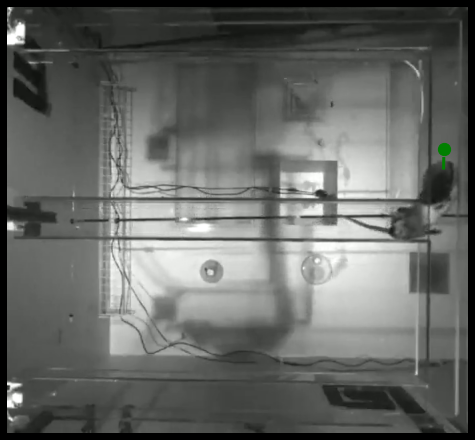

In [279]:
time_slice = slice(22559.4, 22560.4)
movie_name = 'video2.mp4'

make_movie_with_video2(time_slice, results, classifier, video_time,
                       cm_to_pixels, video_filename, video_slowdown=16,
                       movie_name=movie_name)

In [280]:
from ipywidgets import Video

Video.from_file(movie_name)

Video(value=b'\x00\x00\x00 ftypisom\x00\x00\x02\x00isomiso2avc1mp41\x00\x00\x00\x08free\x00\x0c\x9b\xbfmdat\x0…

## Video 3

Animal running with ahead behind distance + only forelimb plant times highlighted [If possible to either make the decode transparent - or maybe an ^ symbol that does not hide the plants being highlighted - it would solve Loren’s issue]

In [75]:
def make_movie_with_video3(time_slice, results, data, classifier, video_time, forelimbL_plant_times,
                           forelimbR_plant_times, cm_to_pixels, video_filename,
                           movie_name='video_name.mp4', sampling_frequency=500, video_slowdown=8):
    
    video_mp4 = cv2.VideoCapture(video_filename)

    posterior = results.causal_posterior.sel(time=time_slice).sum('state')
    map_position = get_2D_map_estimate(posterior, classifier) / cm_to_pixels
    
    position_info = (data['position_info']
             .set_index(data['position_info'].index / np.timedelta64(1, 's'))
             .loc[time_slice])
    bodyparts_to_rgb = {
        'forepawL': (247, 149, 32),
        'forepawR': (134, 76, 158),
    }
    
    forelimbL_plant_time_ind = get_plant_time_ind(
        forelimbL_plant_times, time_slice, posterior.time)
    forelimbL_plant_surrounding_time_ind = forelimbL_plant_time_ind[:, np.newaxis] + np.arange(0, 20)[np.newaxis]
    
    forelimbR_plant_time_ind = get_plant_time_ind(
        forelimbR_plant_times, time_slice, posterior.time)
    forelimbR_plant_surrounding_time_ind = forelimbR_plant_time_ind[:, np.newaxis] + np.arange(0, 20)[np.newaxis]
    
    video_time_ind = np.digitize(posterior.time, video_time[1:-1])
    
    # Set up formatting for the movie files
    Writer = animation.writers['ffmpeg']
    fps = sampling_frequency // video_slowdown
    writer = Writer(fps=fps, bitrate=-1)

    fig, ax = plt.subplots(1, 1, figsize=(6.4, 6.4))
    fig.patch.set_facecolor('black')
    plt.subplots_adjust(top=1, bottom=0, right=1, left=0, 
            hspace=0, wspace=0)
    
    is_grabbed, frame = video_mp4.read()
    if is_grabbed:
        frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
        im = ax.imshow(frame, animated=True, zorder=-1)
    ax.axis('off')
    
    map_dot = ax.scatter([], [], s=150, zorder=50, color='green',
                          label='Decoded position')
    (map_line,) = ax.plot([], [], 'green', linewidth=3, zorder=50)
    
    
    forepawL_dot = ax.scatter([], [], color=np.asarray(bodyparts_to_rgb['forepawL'])/255,
                              s=100, zorder=100, alpha=0.9)
    forepawR_dot = ax.scatter([], [], color=np.asarray(bodyparts_to_rgb['forepawR'])/255,
                              s=100, zorder=100, alpha=0.9)
    
    n_frames = posterior.shape[0]
    progress_bar = tqdm()
    progress_bar.reset(total=n_frames)

    def _update_plot(time_ind):
        progress_bar.update()
        
        start_ind = max(0, time_ind - 5)
        time_slice = slice(start_ind, time_ind)
        
        # Video
        video_mp4.set(1, video_time_ind[time_ind])
        is_grabbed, frame = video_mp4.read()
        if is_grabbed:
            frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
            im.set_array(frame)

        if time_ind in forelimbL_plant_surrounding_time_ind:
            forepawL_dot.set_offsets((frame.shape[1] - position_info['forepawL_x'].iloc[time_ind] / cm_to_pixels[0],
                                position_info['forepawL_y'].iloc[time_ind] / cm_to_pixels[1]))
            forepawL_dot.set_sizes(forepawL_dot.get_sizes() * 1.02)
            forepawL_dot.set_alpha(max(forepawL_dot.get_alpha() * 0.95, 0.0))
        else:
            forepawL_dot.set_offsets((np.nan, np.nan))
            forepawL_dot.set_sizes([100])
            forepawL_dot.set_alpha(0.9)
            
        if time_ind in forelimbR_plant_surrounding_time_ind:
            forepawR_dot.set_offsets((frame.shape[1] - position_info['forepawR_x'].iloc[time_ind] / cm_to_pixels[0],
                                      position_info['forepawR_y'].iloc[time_ind] / cm_to_pixels[1]))
            forepawR_dot.set_sizes(forepawR_dot.get_sizes() * 1.02)
            forepawR_dot.set_alpha(max(forepawR_dot.get_alpha() * 0.95, 0.0))
        else:
            forepawR_dot.set_offsets((np.nan, np.nan))
            forepawR_dot.set_sizes([100])
            forepawR_dot.set_alpha(0.9)

        map_dot.set_offsets((frame.shape[1] - map_position[time_ind, 0], map_position[time_ind, 1]))
        map_line.set_data(frame.shape[1] - map_position[time_slice, 0],
                          map_position[time_slice, 1])

        return (im, map_dot, map_line, forepawL_dot, forepawR_dot)
    
    movie = animation.FuncAnimation(fig, _update_plot, frames=n_frames,
                                    interval=1000/fps, blit=True)
    if movie_name is not None:
        movie.save(movie_name, writer=writer, dpi=200)

    return fig, movie

0it [00:00, ?it/s]

(<Figure size 460.8x460.8 with 1 Axes>,
 <matplotlib.animation.FuncAnimation at 0x7f91f14294a8>)

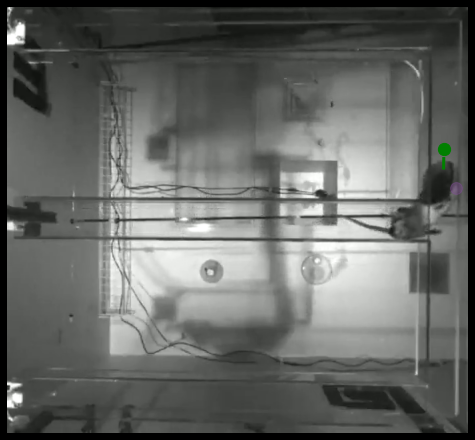

In [76]:
time_slice = slice(22559.4, 22560.4)
movie_name = 'video3.mp4'

make_movie_with_video3(time_slice, results, data, classifier, video_time, forelimbL_plant_times,
                           forelimbR_plant_times, cm_to_pixels, video_filename,
                           movie_name=movie_name, sampling_frequency=500, video_slowdown=16)

In [77]:
from ipywidgets import Video

Video.from_file(movie_name)

Video(value=b'\x00\x00\x00 ftypisom\x00\x00\x02\x00isomiso2avc1mp41\x00\x00\x00\x08free\x00\x0c\xbc\x88mdat\x0…

## Video 4

Animal running with ahead behind distance + only forelimb plant times highlighted + relative distance trace and overlayed plant times.

In [72]:

def make_movie_with_video4(time_slice, results, data, classifier, video_time, forelimbL_plant_times,
                           forelimbR_plant_times, cm_to_pixels, video_filename,
                           movie_name='video_name.mp4', sampling_frequency=500, video_slowdown=8):
    
    video_mp4 = cv2.VideoCapture(video_filename)
    posterior = results.causal_posterior.sel(time=time_slice).sum('state')
    map_position = get_2D_map_estimate(posterior, classifier) / cm_to_pixels
    ahead_behind_distance = np.asarray(results
                                       .sel(time=time_slice)
                                       .rel_distance_from_animal_position_causal)
    max_ab_distance = np.max(np.abs(ahead_behind_distance))
    duration = results.sel(time=time_slice).time[-1] - results.sel(time=time_slice).time[0]
    video_time_ind = np.digitize(posterior.time, video_time[1:-1])
    vmax = np.percentile(posterior.values, 99)
    n_frames = posterior.shape[0]
    
    position_info = (data['position_info']
                 .set_index(data['position_info'].index / np.timedelta64(1, 's'))
                 .loc[time_slice])
    forelimbL_plant_time_ind = get_plant_time_ind(
        forelimbL_plant_times, time_slice, posterior.time)
    forelimbL_plant_surrounding_time_ind = forelimbL_plant_time_ind[:, np.newaxis] + np.arange(0, 20)[np.newaxis]
    
    forelimbR_plant_time_ind = get_plant_time_ind(
        forelimbR_plant_times, time_slice, posterior.time)
    forelimbR_plant_surrounding_time_ind = forelimbR_plant_time_ind[:, np.newaxis] + np.arange(0, 20)[np.newaxis]
    
    bodyparts_to_rgb = {
        'forepawL': (247, 149, 32),
        'forepawR': (134, 76, 158),
    }
    
    progress_bar = tqdm()
    progress_bar.reset(total=n_frames)
    
    # Set up formatting for the movie files
    Writer = animation.writers['ffmpeg']
    fps = sampling_frequency // video_slowdown
    writer = Writer(fps=fps, bitrate=-1)

    fig, axes = plt.subplots(2, 1, figsize=(6.4, 6.4 * 7 / 6),
                             gridspec_kw={"height_ratios": [6, 1]},
                             constrained_layout=False)
    fig.patch.set_facecolor('black')
    plt.subplots_adjust(top=1, bottom=0.15, right=1, left=0, 
                        hspace=0.1, wspace=0.02)
    
    # Axis 0
    is_grabbed, frame = video_mp4.read()
    if is_grabbed:
        frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
        im = axes[0].imshow(frame, animated=True, zorder=-1)
    axes[0].axis('off')
    
    forepawL_dot = axes[0].scatter([], [], color=np.asarray(bodyparts_to_rgb['forepawL'])/255,
                              s=100, zorder=100, alpha=0.9)
    forepawR_dot = axes[0].scatter([], [], color=np.asarray(bodyparts_to_rgb['forepawR'])/255,
                              s=100, zorder=100, alpha=0.9)

    map_dot = axes[0].scatter([], [], s=150, zorder=50, color='green',
                          label='Decoded position')
    (map_line,) = axes[0].plot([], [], 'green', linewidth=3, zorder=50)
    
    # Axes 1
    (ahead_behind_line,) = axes[1].plot([], [], "green", linewidth=2)
    axes[1].axhline(0, color='white', linestyle='--')
    axes[1].set_title('Distance: decoded position to nose [cm]', fontsize=14, color="white")
    axes[1].set_xlabel('Time [s]', fontsize=14, color="white")
    axes[1].set_xlim((0, duration))
    axes[1].set_ylim((-max_ab_distance, max_ab_distance))
    axes[1].set_facecolor("black")
    axes[1].tick_params(colors='white', which='both')
    axes[1].set_aspect(4.2/1000, anchor='C', adjustable='box')
    axes[1].text(1.0, 18, 'Ahead')
    axes[1].text(1.0, -18, 'Behind')
    sns.despine(ax=axes[1])

    def _update_plot(time_ind):
        progress_bar.update()
        start_ind = max(0, time_ind - 5)
        time_slice = slice(start_ind, time_ind)
        
        # Video
        video_mp4.set(1, video_time_ind[time_ind])
        is_grabbed, frame = video_mp4.read()
        if is_grabbed:
            frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
            im.set_array(frame)
        
        if time_ind in forelimbL_plant_surrounding_time_ind:
            forepawL_dot.set_offsets((frame.shape[1] - position_info['forepawL_x'].iloc[time_ind] / cm_to_pixels[0],
                                position_info['forepawL_y'].iloc[time_ind] / cm_to_pixels[1]))
            forepawL_dot.set_sizes(forepawL_dot.get_sizes() * 1.02)
            forepawL_dot.set_alpha(max(forepawL_dot.get_alpha() * 0.95, 0.0))
        else:
            forepawL_dot.set_offsets((np.nan, np.nan))
            forepawL_dot.set_sizes([100])
            forepawL_dot.set_alpha(0.9)
            
        if time_ind in forelimbL_plant_time_ind:
            axes[1].axvline(time_ind/sampling_frequency,
                color=np.asarray(bodyparts_to_rgb['forepawL'])/255)
            
        
        if time_ind in forelimbR_plant_surrounding_time_ind:
            forepawR_dot.set_offsets((frame.shape[1] - position_info['forepawR_x'].iloc[time_ind] / cm_to_pixels[0],
                                      position_info['forepawR_y'].iloc[time_ind] / cm_to_pixels[1]))
            forepawR_dot.set_sizes(forepawR_dot.get_sizes() * 1.02)
            forepawR_dot.set_alpha(max(forepawR_dot.get_alpha() * 0.95, 0.0))
        else:
            forepawR_dot.set_offsets((np.nan, np.nan))
            forepawR_dot.set_sizes([100])
            forepawR_dot.set_alpha(0.9)

        if time_ind in forelimbR_plant_time_ind:
            axes[1].axvline(time_ind/sampling_frequency,
                color=np.asarray(bodyparts_to_rgb['forepawR'])/255)
            
        map_dot.set_offsets((frame.shape[1] - map_position[time_ind, 0], map_position[time_ind, 1]))
        map_line.set_data(frame.shape[1] - map_position[time_slice, 0],
                          map_position[time_slice, 1])
            
        # Axes 1
        ahead_behind_line.set_data(np.arange(time_ind) / sampling_frequency,
                                   ahead_behind_distance[slice(0, time_ind)])

        return map_dot, map_line, ahead_behind_line, im

    movie = animation.FuncAnimation(fig, _update_plot, frames=n_frames,
                                    interval=1000/fps, blit=True)
    if movie_name is not None:
        movie.save(movie_name, writer=writer, dpi=200)

    return fig, movie

0it [00:00, ?it/s]

(<Figure size 460.8x537.12 with 2 Axes>,
 <matplotlib.animation.FuncAnimation at 0x7f91f0143160>)

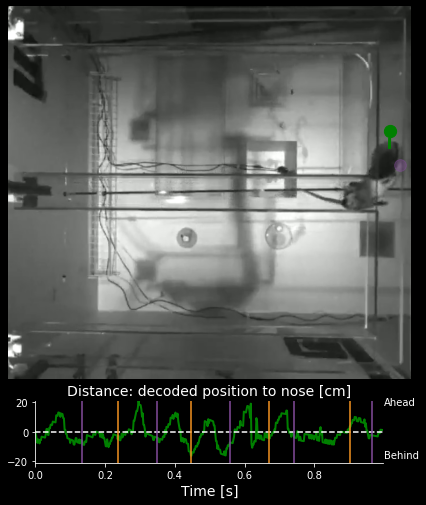

In [73]:
time_slice = slice(22559.4, 22560.4)
movie_name = 'video4.mp4'

make_movie_with_video4(time_slice, results, data, classifier, video_time, forelimbL_plant_times,
                           forelimbR_plant_times, cm_to_pixels, video_filename,
                           movie_name=movie_name, sampling_frequency=500, video_slowdown=16)

In [74]:
from ipywidgets import Video

Video.from_file(movie_name)

Video(value=b'\x00\x00\x00 ftypisom\x00\x00\x02\x00isomiso2avc1mp41\x00\x00\x00\x08free\x00\x0b\xa4rmdat\x00\x…